# Запуск Экспериментов в Azure ML

__Цель лабораторной работы:__

- научиться создавать и запускать Эксперименты (Experiments) Azure ML
- научиться получать детали выполнения Экспериментов.

## Подготовка среды

Импорт необходимых модулей и проверка версии Azure ML SDK:

In [13]:
import os

import azureml.core
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.datastore import Datastore

from datetime import datetime
import json

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Check core SDK version number
print(f'SDK version: {azureml.core.VERSION}')

SDK version: 1.14.0


Получим конфигурацию эксперимента:

In [ ]:
%run core.py

config = get_experiment_config('lab_4A')
config

## Соединение со Azure ML Workspace

Устанавливаем соединение с Рабочей областью в Azure ML:

In [5]:
ws = Workspace.from_config()
print(f'Successfully connected to Workspace: {ws.name}.')

Successfully connected to Workspace: aml-workshop.


## Загрузка данных для Эксперимента

Просмотрим список зарегистрированных Наборов данных:

In [8]:
print([ds for ds in Dataset.get_all(ws)])

['diabetes-data', 'diabetes-data-ui']


Выберем `diabetes-data` в качестве Набора данных для Эксперимента:

In [9]:
diabetes_ds = ws.datasets.get(config['core']['dataset_name'])

data = diabetes_ds.to_pandas_dataframe()
data.sample(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
1521,1794450,9,98,49,34,23,21.478359,0.221670,34,0
12122,1572299,10,106,71,49,285,50.840548,0.878405,21,1
11038,1831041,1,145,25,44,528,21.632402,0.182613,24,0
7043,1214343,3,174,65,13,85,37.072200,0.896743,43,1
4060,1984010,0,69,59,40,75,36.568040,0.162043,35,0
7015,1429037,4,77,81,39,271,30.991208,0.515925,23,1
111,1147574,0,146,54,33,192,20.375412,0.170665,23,0
11306,1512400,1,165,79,20,188,43.218111,0.665186,21,0
9916,1607701,1,97,83,12,190,21.289828,0.184932,23,0
598,1448054,1,71,61,17,63,45.100124,0.293332,25,0


## Запуск Эксперимента

Создадим Эксперимент и залогируем основные данные об Эксперименте, а также информацию о данных используемых в нем:

In [10]:
# Create an Azure ML experiment
experiment = Experiment(workspace=ws, name=config['experiment_name'])

# Create an interactive run
run = experiment.start_logging()

run.tag('healthcare')
run.tag('azure-ml-workshop')

run.log('Dataset dimension', f'{data.shape[0]}x{data.shape[1]}')
run.log('Yet another important fact', 'Think about it')

print(f'Starting experiment {experiment.name}...')

Starting experiment my-1st-experiment...


## Анализ данных

Построим __гистограмму частот__, для того чтобы проанализировать количество пациентов с диабетом и без, а затем залогируем результаты:

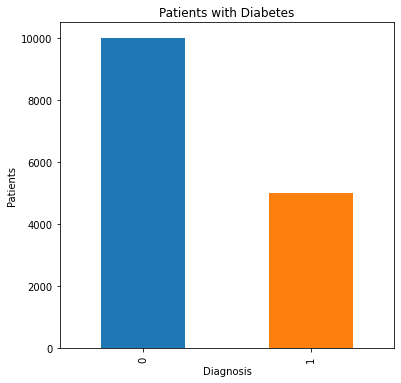

In [11]:
# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()    

diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

Построим __матрицу корреляции__ признаков в данных и залогируем результат:

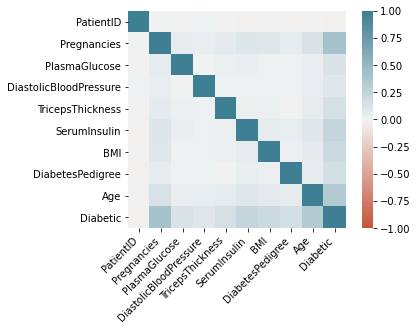

In [12]:
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

run.log_image(name='correlation matrix', plot=ax.get_figure())

Построим boxplot-графики:

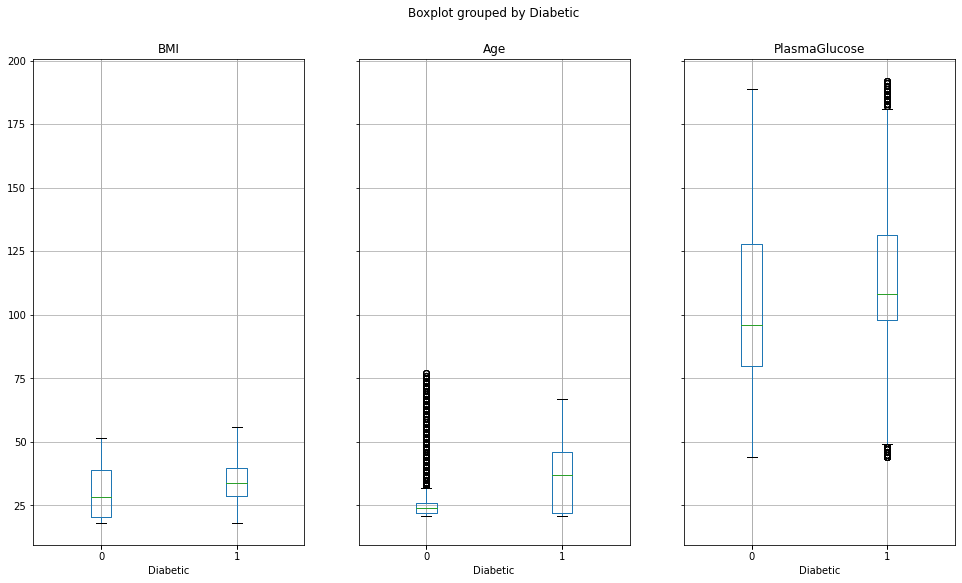

In [15]:
bxp = data.boxplot(column=['BMI', 'Age', 'PlasmaGlucose'], by='Diabetic', layout=(1, 3), figsize=(16, 9))

Посчитаем __описательные статистики__ датасета и залогируем результаты:

In [16]:
# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])

Сохраним 100 случайных строк из данных в выходные данные Эксперимента:

In [17]:
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream = './sample.csv')

## Завершение Эксперимента и просмотр результатов:

Завершим запуск Эксперимента, вызвав метод `complete()`:

In [19]:
# Complete the run
run.complete()

Детали эксперимента:

In [ ]:
details = run.get_details()
print(details)

Метрики эксперимента:

In [ ]:
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

Выходные данные:

In [22]:
files = run.get_file_names()
print(json.dumps(files, indent=2))

[
  "correlation matrix_1600870020.png",
  "label distribution_1600870012.png",
  "outputs/sample.csv"
]


Визуализируем данные с помощью виджета:

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

Перейдите по сссылке, которая появилась в виджете (выше), чтобы просмотеть результаты Эксперимента на протале Azure ML.